In [4]:
# For wider display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
from scipy import integrate, special
%matplotlib inline

# Date: 20/10/2021
### Currently trying to get analytic expression that demonstrates that the initially positive slope predicted by the VAH model under the assumption that we can calculate the transport coefficients with the conformal expression is valid

The evolution equations for viscous anisotropic hydrodynamics are (where the transport coefficients $\zeta_z^\perp$ and $\zeta_z^L$ are assumed to be those for a conformal system)
\begin{align}
\frac{d\mathcal E}{d\tau}
& = 
-\frac{\mathcal E + \mathcal P_L}{\tau} \\
\frac{d\mathcal P_\perp}{d\tau} & =
-\frac{\Pi}{\tau_R} - \frac{\pi}{2\tau_R} + \frac{\zeta_z^\perp}{\tau}, &
    \zeta_z^\perp &= \mathcal{I}_{2210} - \mathcal P_\perp \approx \frac{\mathcal E}{2}\frac{R_{221}(\xi)}{R_{200}(\xi)} - \mathcal P_\perp\\
\frac{d\mathcal P_L}{d\tau} 
& = 
-\frac{\Pi}{\tau_R} + \frac{\pi}{\tau_R} + \frac{\zeta_z^L}{\tau}, &
    \zeta_z^L &= \mathcal I_{2400} - 3\mathcal P_L \approx \mathcal E\frac{R_{240}(\xi)}{R_{200}(\xi)} - 3\mathcal P_L 
\end{align}
where 
\begin{equation}
\Pi = \frac{\mathcal P_L + 2 \mathcal P_\perp}{3} - \mathcal P_\mathrm{eq}
\quad \text{and} \quad
\pi = \frac{2}{3}\left(\mathcal P_\perp - \mathcal P_L\right).
\end{equation}   

To derive a evolution equation for $\Pi$, we need to derive an evolution equation fo $\mathcal P_\mathrm{eq}$.
We recall that for a Boltzmann gas, the thermal energy density and pressure are given by
\begin{align}
    \mathcal E & = \frac{3T^4}{\pi^2}\left\lbrack\frac{z^2}{2}K_2(z) + \frac{z^3}{6}K_1(z)\right\rbrack \\
    \mathcal P_\mathrm{eq} & = \frac{T^4}{2\pi^2}K_2(z)
\end{align}
where $T$ is the temperaturem, $ z=m/T$ the reatio of mass to temperaturem and $K_n(z)$ is the $n-$th 
Bessel function of the second kind.
The behavior of $K_n(z)$ near $z=0$ to leading order is proportional to $z^{-n}$.
We see that in the small mass limit, we can then approximate the $\mathcal P_\mathrm{eq}$ evolution as
\begin{equation}
    \frac{d\mathcal P_\mathrm{eq}}{d\tau} = \frac{1}{3} \frac{d\mathcal E}{d\tau}.
\end{equation}
Finally, we can approximate $\Pi$ evolution as 
\begin{equation}
    \frac{d\Pi}{d\tau} = -\frac{\Pi}{\tau_R} + \frac{1}{3\tau}\left\lbrack
    \mathcal E\frac{R_{221}(\xi) + R_{240}(\xi)}{R_{200}(\xi)}
    -2\left(\mathcal P_L + \mathcal P_\perp\right) + \mathcal E 
    \right\rbrack
\end{equation}

Some expressions that we will need are:
* relaxation time 
$$ \tau_R(\tau) = \frac{5\mathcal C}{T(\tau)} $$
* $R-$ functions
\begin{align}
    R_{200}(\xi) & = \frac{1}{2}\left\lbrack \frac{1}{1+\xi} + \frac{\tan^{-1}\sqrt\xi}{\sqrt\xi}\right\rbrack \\
    R_{221}(\xi) & = \frac{1}{2\xi^2}\left\lbrack -3 + (3+\xi) \frac{\tan^{-1}\sqrt\xi}{\sqrt\xi}\right\rbrack \\
    R_{240}(\xi) & = \frac{1}{2\xi^2}\left\lbrack\frac{3+2\xi}{1+\xi} - 3 \frac{\tan^{-1}\sqrt\xi}{\sqrt\xi}\right\rbrack
\end{align}


In [3]:
# define R-functions needed to calculate transport coefficient
def R200(xi):
    if xi < 0:
        r = np.arctanh(np.sqrt(-xi)) / np.sqrt(-xi)
    elif xi > 0:
        r = np.arctan(np.sqrt(xi)) / np.sqrt(xi)
    else:
        return 1.0
    
    return 0.5 * (1 / (1 + xi) + r)

def R221(xi):
    if xi < 0:
        r = np.arctanh(np.sqrt(-xi)) / np.sqrt(-xi)
    elif xi > 0:
        r = np.arctan(np.sqrt(xi)) / np.sqrt(xi)
    else:
        return 4 / 30
    
    return (-3 + (3 + xi) * r) / (2 * xi ** 2)
        
        
def R240(xi):
    if xi < 0:
        r = np.arctanh(np.sqrt(-xi)) / np.sqrt(-xi)
    elif xi > 0:
        r = np.arctan(np.sqrt(xi)) / np.sqrt(xi)
    else:
        return 0.2
    
    return ((3 + 2 * xi) / (1 + xi) - 3 * r) / (2 * xi ** 2)

In [92]:
def dPi_dtau_vah(E, PT, PL, Peq, T, tau, xi, C):
    zeta_L = E * R240(xi) / R200(xi) - 3 * PL
    zeta_T = E * R221(xi) / R200(xi) / 2 - PT
    
    Pi = (PL + 2 * PT) / 3 - Peq
    tr = 5 * C / T
    
    print("zeta_L:", zeta_L)
    print("zeta_T:", zeta_T)
    print("Pi / tr:", Pi / tr)
    print("E + PL:", PL + E)
    
    return - Pi / tr + (zeta_L + 2 * zeta_T + PL + E) / (3 * tau)

def dPi_dtau_vah_realistic(E, PT, PL, Peq, T, tau, xi, m, C):
    def Inrqs(n, r, q, s):
        alpha_T = 1
        alpha_L = 1 / np.sqrt(1 + xi)
        Lambda = 1.647204044
        
        def integrand(pT, pz):
            Eeq = np.sqrt(m ** 2 + pT ** 2 + pz ** 2)
            Ea = np.sqrt(m ** 2 + (pT / alpha_T) ** 2 + (pz / alpha_L) ** 2)
            return Eeq ** (n - r - 2 * q - 1) * pz ** r * pT ** (2 * q + 1) * Ea ** s * np.exp(-Ea / Lambda)
        
        return integrate.dblquad(integrand, 0, np.inf, 0, np.inf)[0] / (2 * np.pi ** 2 * special.factorial2(2 * q))
    
    Pi = (PL + 2 * PT) / 3 - Peq
    tr = 5 * C / T
    
    zeta_L = Inrqs(2,4,0,0) - 3 * PL
    zeta_T = Inrqs(2,2,1,0) - PT
    
    print("zeta_L:", zeta_L)
    print("zeta_T:", zeta_T)
    print("Pi / tr:", Pi / tr)
    print("E + PL:", PL + E)
    
    return (zeta_L + 2 * zeta_T + E + PL) / (3 * tau0)#-Pi / tr + (zeta_L + 2 * zeta_T + E + PL) / (3 * tau)


def anisotropic_transport_coeff(E, PT, PL, Peq, T, tau, xi, m, C):
    zeta_L = E * R240(xi) / R200(xi) - 3 * PL
    zeta_T = E * R221(xi) / R200(xi) / 2 - PT
    
    def Inrqs(n, r, q, s):
        alpha_T = 1
        alpha_L = 1 / np.sqrt(1 + xi)
        Lambda = 1.647204044
        
        def integrand(pT, pz):
            Eeq = np.sqrt(m ** 2 + pT ** 2 + pz ** 2)
            Ea = np.sqrt(m ** 2 + (pT / alpha_T) ** 2 + (pz / alpha_L) ** 2)
            return Eeq ** (n - r - 2 * q - 1) * pz ** r * pT ** (q + 1) * Ea ** s * np.exp(-Ea / Lambda)
        
        return integrate.dblquad(integrand, 0, np.inf, 0, np.inf)[0] / (2 * np.pi ** 2 * special.factorial2(2 * q))
    
    zeta_T_real = Inrqs(2,2,1,0) - PT
    zeta_L_real = Inrqs(2,4,0,0) - 3 * PL
    
    return zeta_L, zeta_T, zeta_L_real, zeta_T_real

In [5]:
special.factorial(5)

120.0

In [6]:
E = 12.43951
PT = 1.98753
PL = 8.17055
Peq = 4.04854
T = 2.52579
tau = 0.1
xi = -0.999
C = 0.1777
m = 0.001 / 0.197 #1.015228426

print(dPi_dtau_vah(E, PT, PL, Peq, T, tau, xi, C))
print(dPi_dtau_vah_realistic(E, PT, PL, Peq, T, tau, xi, m, C))

14.908063557047322
I_2400 = 1043.504128147922
I_2210 = 0.5804527570236375
3455.9612883490895


In [35]:
E = 0.6787133
PT = 0.289026
PL = 0.165035
Peq = 0.208395
T = 1.24047
tau = 0.1
xi = -0.5
C = 0.5
m = 0.001 / 0.197 #1.015228426

print(dPi_dtau_vah(E, PT, PL, Peq, T, tau, xi, C))
print(dPi_dtau_vah_realistic(E, PT, PL, Peq, T, tau, xi, m, C))
print(anisotropic_transport_coeff(E, PT, PL, Peq, T, tau, xi, m, C))

0.26606693350583793
3.1095942448911376
(-0.2771369209532416, -0.24047057161870344, 0.18143702708005205, -0.22921494892755534)


Next we present the expressions for the viscous theories for the slope.
The evolution equation for the bulk stress is given by 
\begin{equation}
\frac{d\Pi}{d\tau} = 
    -\frac{\Pi}{\tau_R} - \frac{\beta_\Pi + \delta_{\Pi\Pi}\Pi - \lambda_{\Pi\pi}\pi}{\tau}
\end{equation}
where the transport coefficients are given by (left, Chapman Enskog and right, DNMR)
\begin{align}
    \tau_R(\tau) & = \frac{5 \mathcal C}{T(\tau)} & 
    \tau_R(\tau) & = \frac{5 \mathcal C}{T(\tau)} \\
    \beta_\Pi & = \frac{5}{3}\beta J_{32} - (\mathcal E +\mathcal P_\mathrm{eq})c_s^2 &
    \beta_\Pi & = \frac{5}{3}\beta J_{32} - (\mathcal E + \mathcal P_\mathrm{eq})c_s^2 \\
    \delta_{\Pi\Pi} & = -\frac{5}{9}\chi - c_s^2 & 
    \delta_{\Pi\Pi} & = 1-c_s^2-\frac{1}{9}m^4(\bar c_\mathcal{E}J_{00} + \bar c_\Pi J_{01}) \\
    \lambda_{\Pi\pi} & = \frac{1}{3J_{32}}\left(7I^{(3)}_{63} + 2 J_{32}\right) - c_s^2 & 
    \lambda_{\Pi\pi} & = \frac{1}{3} - c_s^2 + \frac{1}{3}m^2 \bar c_\pi J_{22}
\end{align}
where we have introduced the additional symbols:
\begin{align}
    J_{nq} & = \frac{1}{(2q+1)!!} \int \frac{d^3 p}{(2\pi)^3} 
    (p ^ 2 + m ^ 2)^{(n-2q-1)/2} p^ q \exp(-E / T) \\
    \bar c_\pi &= \frac{1}{J_{42}} \\
    \bar c_\mathcal{E} &= - J_{41}\left(\frac{5}{3}J_{40} j_{42} - J_{41}^2\right)^{-1} \\
    \bar c_\Pi &= J_{40} \left(\frac{5}{3} J_{40} J_{42} - J_{41}^2\right)^{-1} \\
   c_s^2 & = 
   \frac{\mathcal E + \mathcal P_\mathrm{eq}}{3\mathcal E + (3+z^2)\mathcal P_\mathrm{eq}} \\
    z & = \frac{m}{T} .
\end{align}
Lastly, we define the $\chi$ as 
\begin{align}
    \chi & = \frac{\beta}{\beta_\Pi}
    \left\lbrack
        (1 - 3c_s^2)\left(I^{(1)}_{42} + I^{(0)}_{31}\right)
        - m^2 \left(I^{(3)}_{42} + I^{(2)}_{31}\right)
    \right\rbrack \\
    I^{(3)}{_63} & = -\frac{T^5z^5}{210 \pi^2}
    \left\lbrack
        (K_5 - 11 K_3 + 58 K_1) - 4 K_{i,1} + k_{i,3}
    \right\rbrack \\
    I^{(1)}_{42} & = \frac{T^5 z^3}{30\pi^2}
    \left\lbrack
        \frac{1}{16}(K_5 - 7K_3 + 2K_1) - K_{i,1}
    \right\rbrack \\
    I^{(3)}_{42} & = \frac{T^3z^3}{30\pi^2}
    \left\lbrack
        \frac{1}{4}(K_3 - 9K_1)+3K_{i,1} - K_{i,3}
    \right\rbrack \\
    I^{(0)}_{31} & = -\frac{1}{\beta}(\mathcal E + \mathcal P_\mathrm{eq}) \\
    I^{(2)}_{31} & = -\frac{T^3z^3}{6\pi^2}
    \left\lbrack
        \frac{1}{4}(K_3-5K_1)+K_{i,1}
    \right\rbrack
\end{align}
where $K_n=K_n(z)$ are the $n^\mathrm{th}$ Bessel functions of the second kind and 
\begin{equation}
    K_{i,n}(z) = \int_0^\infty \frac{d\theta}{(\cosh\theta)^n}\exp{(-z\cosh\theta)}. 
\end{equation}


In [8]:
def dPi_dtau_viscous(E, PT, PL, Peq, T, tau, m, C, flag):
    # setup other functions that will be called
    def Jnq(n, q, m, T):
        def integrand(x):
            return (x ** 2 - 1) ** (0.5 * (2 * q + 1)) * x ** (n - 2 * q) * np.exp(- m / T * x)
        return m ** (n + 2) * integrate.quad(integrand, 1, np.inf)[0] / (special.factorial2(2 * q + 1) * 2 * np.pi ** 2)
    def Kin(n, z):
        return integrate.quad(lambda th : np.exp(- z * np.cosh(th)) / np.cosh(th) ** n, 0, np.inf)[0]
     
    # mass temperature
    z = m/T
    beta = 1/T
    
    cs2 = (E + Peq) / (3 * E + (3 + z ** 2) * Peq)
    
    tauR = 5 * C / T
    
    if flag == 'ce':    
        K5 = special.kn(5, z)
        K3 = special.kn(3, z)
        K1 = special.kn(1, z)

        Ki3 = Kin(3, z)
        Ki1 = Kin(1, z)
        
        I3_63 = -(T * z) ** 5 / (210 * np.pi ** 2) * ((K5 - 11 * K3 + 58 * K1) / 16 - 4 * Ki1 + Ki3)
        I1_42 = (T * z) ** 5 / (30 * np.pi ** 2) * ((K5 - 7 * K3 + 22 * K1) / 16 - Ki1)
        I3_42 = (T * z) ** 3 / (30 * np.pi ** 2) * ((K3 - 9 * K1) / 4 + 3 * Ki1 - Ki3)
        I0_31 = -(E + Peq) / beta
        I2_31 = -(T * z) ** 3 / (6 * np.pi ** 2) * ((K3 - 5 * K1) / 4 + Ki1)
        
        beta_Pi = (5 / 3) * beta * I1_42- (E + Peq) * cs2
        chi = beta / beta_Pi * ((1 - 3 * cs2) * (I1_42 + I0_31) - m ** 2 * (I3_42 + I2_31))
    
        delta_PiPi = -(5/9) * chi - cs2
        lambda_Pipi = 1 / (3 * I1_42) * (7 * I3_63 + 2 * I1_42) - cs2
    else: 
        J00 = Jnq(0, 0, m, T)
        J01 = Jnq(0, 1, m, T)
        J22 = Jnq(2, 2, m, T)
        J32 = Jnq(3, 2, m, T)
        J40 = Jnq(4, 0, m, T)
        J41 = Jnq(4, 1, m, T)
        J42 = Jnq(4, 2, m, T)
        
        cbar_pi = 1 / (2 * J42)
        cbar_e = - J41 / ((5/3) * J40 * J42 - J41 ** 2)
        cbar_Pi = J40 / ((5/3) * J40 * J42 - J41 ** 2)
        
        beta_Pi = (5 / 3) * beta * J32 - (E + Peq) * cs2
        delta_PiPi = 1 - cs2 - (1/9) * m ** 4 * (cbar_e * J00 + cbar_Pi * J01)
        lambda_Pipi = 1/3 - cs2 + (1/3) * m ** 2 * cbar_pi * J22
        
    Pi = (PL + 2 * PT) / 3 - Peq
    pi = (2/3) * (PT - PL)
    
    return - Pi / tauR - (beta_Pi + delta_PiPi * Pi - lambda_Pipi * pi) / tau

def viscous_transport_coeff(E, PT, PL, Peq, T, tau, m, C, flag):
    def Jnq(n, q, m, T):
        def integrand(x):
            return (x ** 2 - 1) ** (0.5 * (2 * q + 1)) * x ** (n - 2 * q) * np.exp(- m / T * x)
        return m ** (n + 2) * integrate.quad(integrand, 1, np.inf)[0] / (special.factorial2(2 * q + 1) * 2 * np.pi ** 2)
    def Kin(n, z):
        return integrate.quad(lambda th : np.exp(- z * np.cosh(th)) / np.cosh(th) ** n, 0, np.inf)[0]
    
    # mass temperature
    z = m/T
    beta = 1/T
    
    cs2 = (E + Peq) / (3 * E + (3 + z ** 2) * Peq)
    
    tauR = 5 * C / T
    
    if flag == 'ce':    
        K5 = special.kn(5, z)
        K3 = special.kn(3, z)
        K1 = special.kn(1, z)

        Ki3 = Kin(3, z)
        Ki1 = Kin(1, z)
        
        I3_63 = -(T * z) ** 5 / (210 * np.pi ** 2) * ((K5 - 11 * K3 + 58 * K1) / 16 - 4 * Ki1 + Ki3)
        I1_42 = (T * z) ** 5 / (30 * np.pi ** 2) * ((K5 - 7 * K3 + 22 * K1) / 16 - Ki1)
        I3_42 = (T * z) ** 3 / (30 * np.pi ** 2) * ((K3 - 9 * K1) / 4 + 3 * Ki1 - Ki3)
        I0_31 = -(E + Peq) / beta
        I2_31 = -(T * z) ** 3 / (6 * np.pi ** 2) * ((K3 - 5 * K1) / 4 + Ki1)
        
        beta_Pi = (5 / 3) * beta * I1_42- (E + Peq) * cs2
        chi = beta / beta_Pi * ((1 - 3 * cs2) * (I1_42 + I0_31) - m ** 2 * (I3_42 + I2_31))
    
        delta_PiPi = -(5/9) * chi - cs2
        lambda_Pipi = 1 / (3 * I1_42) * (7 * I3_63 + 2 * I1_42) - cs2
    else: 
        J00 = Jnq(0, 0, m, T)
        J01 = Jnq(0, 1, m, T)
        J22 = Jnq(2, 2, m, T)
        J32 = Jnq(3, 2, m, T)
        J40 = Jnq(4, 0, m, T)
        J41 = Jnq(4, 1, m, T)
        J42 = Jnq(4, 2, m, T)
        
        cbar_pi = 1 / (2 * J42)
        cbar_e = - J41 / ((5/3) * J40 * J42 - J41 ** 2)
        cbar_Pi = J40 / ((5/3) * J40 * J42 - J41 ** 2)
        
        beta_Pi = (5 / 3) * beta * J32 - (E + Peq) * cs2
        delta_PiPi = 1 - cs2 - (1/9) * m ** 4 * (cbar_e * J00 + cbar_Pi * J01)
        lambda_Pipi = 1/3 - cs2 + (1/3) * m ** 2 * cbar_pi * J22
    
    return beta_Pi, delta_PiPi, lambda_Pipi

In [9]:
E = 0.6787133
PT = 0.289026
PL = 0.165035
Peq = 0.208395
T = 1.24047
tau = 0.1
m = 0.001 / 0.197 #0.200 / 0.197
C = 0.5

print(dPi_dtau_viscous(E, PT, PL, Peq, T, tau, m, C, 'ce'))
print(dPi_dtau_viscous(E, PT, PL, Peq, T, tau, m, C, 'dnmr'))

-0.8219276146956896
-0.31427369951736656


C:\Users\gil-c\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
C:\Users\gil-c\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in cosh
  


### Next, I make a plot where I calculate various initial data from the RTA solution and simply vary $\xi_0$, to show that for the full spectrum of $\xi$ values, we do not observer a negative initial slope

Other important information: $m = 200 MeV$

In [10]:
import scipy.special as special

import matplotlib.pyplot as plt
import matplotlib.ticker as tck

In [11]:
import matplotlib.font_manager
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def costumize_axis(ax, x_title, y_title):
    ax.set_xlabel(x_title, fontsize=24)
    ax.set_ylabel(y_title, fontsize=24)
    ax.tick_params(axis='both', labelsize=18)
    ax.tick_params(axis='both', which='major', length=8)
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.tick_params(axis='both', which='minor', direction='in', length=4)
    return ax

In [12]:
def GetTemperature(e, m):
    def Eeq(T, z):
        if z == 0:
            return 3.0 * T ** 4 / np.pi ** 2
        else:
            return (3.0 * T ** 4 / np.pi ** 2) * (z ** 2 * special.kn(2, z) / 2.0 + z ** 3 * special.kn(1, z) / 6.0)

    Tmin = 0.001 / 0.197
    Tmax = 2.0 / 0.197
    n = 0; flag = True
    Tmid = 0
    while flag and n <= 2000:
        Tmid = (Tmin + Tmax) / 2.0
        emid = Eeq(Tmid, m / Tmid)
        emin = Eeq(Tmin, m / Tmin)
        if np.fabs(emid - e) < 1e-6:
            break
        if (emid - e) * (emin - e) <= 0:
            Tmax = Tmid
        else:
            Tmin = Tmid
        n += 1
        if n == 1:
            Tcopy = Tmid
        if n > 4:
            if np.fabs(Tcopy - Tmid) < 1e-6:
                flag = False
            Tcopy = Tmid

    return Tmid

In [62]:
C = [1 / (4 * np.pi), 10 / (4 * np.pi)]

with open(f'./output/initial_values_C={C[0]:.3f}.dat', 'r') as f:
    in_data1 = np.array([[float(entry) for entry in line.split()] for line in f.readlines()])

with open(f'./output/initial_values_C={C[1]:.3f}.dat', 'r') as f:
    in_data2 = np.array([[float(entry) for entry in line.split()] for line in f.readlines()])

xis = np.zeros(in_data1.shape[0])
Pis1 = np.zeros_like(xis)
Pis2 = np.zeros_like(xis)

dPi_dtaus_vah1 = np.zeros_like(xis)
dPi_dtaus_vah2 = np.zeros_like(xis)
dPi_dtaus_vah1_realistic = np.zeros_like(xis)
dPi_dtaus_vah2_realistic = np.zeros_like(xis)
dPi_dtaus_ce1 = np.zeros_like(xis)
dPi_dtaus_ce2 = np.zeros_like(xis)
dPi_dtaus_dnmr1 = np.zeros_like(xis)
dPi_dtaus_dnmr2 = np.zeros_like(xis)

zeta_Ls = np.zeros((2,xis.size))
zeta_Ts = np.zeros_like(zeta_Ls)
zeta_Ls_real = np.zeros((2,xis.size))
zeta_Ts_real = np.zeros_like(zeta_Ls)

delta_PiPi_ce = np.zeros_like(zeta_Ls)
lambda_Pipi_ce = np.zeros_like(zeta_Ls)
beta_Pi_ce = np.zeros_like(zeta_Ls)

delta_PiPi_dnmr = np.zeros_like(zeta_Ls)
lambda_Pipi_dnmr = np.zeros_like(zeta_Ls)
beta_Pi_dnmr = np.zeros_like(zeta_Ls)


m = 0.001 / 0.197 #1.01523
tau0 = 0.1
for i in range(xis.size):
    t, e, p, pt, pl, xi = in_data1[i]
    T = GetTemperature(e, m)
    xis[i] = xi
    Pis1[i] = (pl + 2 * pt) / 3 - p
    dPi_dtaus_vah1[i] = dPi_dtau_vah(e, pt, pl, p, T, t, xi, C[0])
    dPi_dtaus_vah1_realistic[i] = dPi_dtau_vah_realistic(e, pt, pl, p, T, t, xi, m, C[0])
    dPi_dtaus_ce1[i] = dPi_dtau_viscous(e, pt, pl, p, T, t, m, C[0], 'ce')
    dPi_dtaus_dnmr1[i] = dPi_dtau_viscous(e, pt, pl, p, T, t, m, C[0], 'dnmr')
    
    t, e, p, pt, pl, xi = in_data2[i]
    T = GetTemperature(e, m)
    Pis2[i] = (pl + 2 * pt) / 3 - p
    dPi_dtaus_vah2[i] = dPi_dtau_vah(e, pt, pl, p, T, t, xi, C[1])
    dPi_dtaus_vah2_realistic[i] = dPi_dtau_vah_realistic(e, pt, pl, p, T, t, xi, m, C[1])
    dPi_dtaus_ce2[i] = dPi_dtau_viscous(e, pt, pl, p, T, t, m, C[1], 'ce')
    dPi_dtaus_dnmr2[i] = dPi_dtau_viscous(e, pt, pl, p, T, t, m, C[1], 'dnmr')
    
    zeta_Ls[0,i], zeta_Ts[0,i], zeta_Ls_real[0,i], zeta_Ts_real[0,i]  = anisotropic_transport_coeff(e, pt, pl, p, T, t, xi, m, C[0])
    zeta_Ls[1,i], zeta_Ts[1,i], zeta_Ls_real[1,i], zeta_Ts_real[1,i]  = anisotropic_transport_coeff(e, pt, pl, p, T, t, xi, m, C[1])
    
    beta_Pi_ce[0,i], delta_PiPi_ce[0,i], lambda_Pipi_ce[0,i] = viscous_transport_coeff(e, pt, pl, p, T, t, m, C[0], 'ce')
    beta_Pi_ce[1,i], delta_PiPi_ce[1,i], lambda_Pipi_ce[1,i] = viscous_transport_coeff(e, pt, pl, p, T, t, m, C[1], 'ce')
    
    beta_Pi_dnmr[0,i], delta_PiPi_dnmr[0,i], lambda_Pipi_dnmr[0,i] = viscous_transport_coeff(e, pt, pl, p, T, t, m, C[0], 'dnmr')
    beta_Pi_dnmr[1,i], delta_PiPi_dnmr[1,i], lambda_Pipi_dnmr[1,i] = viscous_transport_coeff(e, pt, pl, p, T, t, m, C[1], 'dnmr') 

C:\Users\gil-c\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
C:\Users\gil-c\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in cosh
  
C:\Users\gil-c\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  
C:\Users\gil-c\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in double_scalars
C:\Users\gil-c\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in cosh
C:\Users\gil-c\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It 

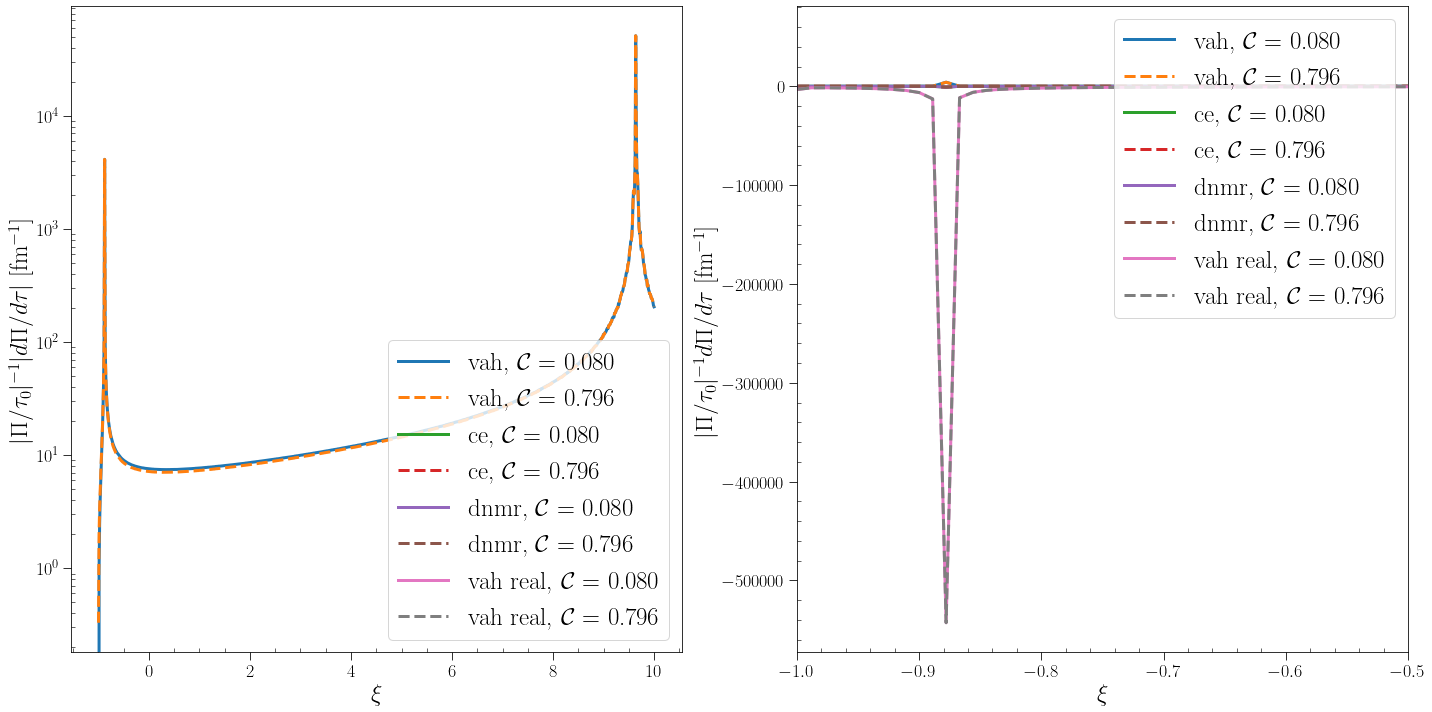

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
fig.patch.set_facecolor('white')

cmap = get_cmap(10, 'tab10')
ax[0].plot(xis, dPi_dtaus_vah1 / (np.abs(Pis1) / tau0), lw=3, color=cmap(0), label=r'vah, $\mathcal C=\ $'+f'{C[0]:.3f}')
ax[0].plot(xis, dPi_dtaus_vah2 / (np.abs(Pis2) / tau0), lw=3, color=cmap(1), ls='dashed', label=r'vah, $\mathcal C=\ $'+f'{C[1]:.3f}')
ax[0].plot(xis, dPi_dtaus_ce1 / (np.abs(Pis1) / tau0), lw=3, color=cmap(2), label=r'ce, $\mathcal C=\ $'+f'{C[0]:.3f}')
ax[0].plot(xis, dPi_dtaus_ce2 / (np.abs(Pis2) / tau0), lw=3, color=cmap(3), ls='dashed', label=r'ce, $\mathcal C=\ $'+f'{C[1]:.3f}')
ax[0].plot(xis, dPi_dtaus_dnmr1 / (np.abs(Pis1) / tau0), lw=3, color=cmap(4), label=r'dnmr, $\mathcal C=\ $'+f'{C[0]:.3f}')
ax[0].plot(xis, dPi_dtaus_dnmr2 / (np.abs(Pis2) / tau0), lw=3, color=cmap(5), ls='dashed', label=r'dnmr, $\mathcal C=\ $'+f'{C[1]:.3f}')
ax[0].plot(xis, dPi_dtaus_vah1_realistic / (np.abs(Pis1) / tau0), lw=3, color=cmap(6), label=r'vah real, $\mathcal C=\ $'+f'{C[0]:.3f}')
ax[0].plot(xis, dPi_dtaus_vah2_realistic / (np.abs(Pis2) / tau0), lw=3, color=cmap(7), ls='dashed', label=r'vah real, $\mathcal C=\ $'+f'{C[1]:.3f}')
costumize_axis(ax[0], r'$\xi$', r'$|\Pi/\tau_0|^{-1} |d\Pi/d\tau|$ [fm$^{-1}$]')
ax[0].set_yscale('log')
#ax[0].set_ylim((1e-10,1e3))
ax[0].legend(loc='lower right', fontsize=25)

scale = 1
ax[1].axhline(y=0, lw=1, color='black')
ax[1].plot(xis, dPi_dtaus_vah1           / (np.abs(Pis1) / tau0), lw=3, color=cmap(0), label=r'vah, $\mathcal C=\ $'+f'{C[0]:.3f}')
ax[1].plot(xis, dPi_dtaus_vah2           / (np.abs(Pis2) / tau0), lw=3, color=cmap(1), ls='dashed', label=r'vah, $\mathcal C=\ $'+f'{C[1]:.3f}')
ax[1].plot(xis, dPi_dtaus_ce1            / (np.abs(Pis1) / tau0), lw=3, color=cmap(2), label=r'ce, $\mathcal C=\ $'+f'{C[0]:.3f}')
ax[1].plot(xis, dPi_dtaus_ce2            / (np.abs(Pis2) / tau0), lw=3, color=cmap(3), ls='dashed', label=r'ce, $\mathcal C=\ $'+f'{C[1]:.3f}')
ax[1].plot(xis, dPi_dtaus_dnmr1          / (np.abs(Pis1) / tau0), lw=3, color=cmap(4), label=r'dnmr, $\mathcal C=\ $'+f'{C[0]:.3f}')
ax[1].plot(xis, dPi_dtaus_dnmr2          / (np.abs(Pis2) / tau0), lw=3, color=cmap(5), ls='dashed', label=r'dnmr, $\mathcal C=\ $'+f'{C[1]:.3f}')
ax[1].plot(xis, dPi_dtaus_vah1_realistic / (np.abs(Pis1) / tau0), lw=3, color=cmap(6), label=r'vah real, $\mathcal C=\ $'+f'{C[0]:.3f}')
ax[1].plot(xis, dPi_dtaus_vah2_realistic / (np.abs(Pis2) / tau0), lw=3, color=cmap(7), ls='dashed', label=r'vah real, $\mathcal C=\ $'+f'{C[1]:.3f}')
costumize_axis(ax[1], r'$\xi$', r'$|\Pi/\tau_0|^{-1} d\Pi/d\tau$ [fm$^{-1}$]')
ax[1].legend(loc='upper right', fontsize=25)
ax[1].set_xlim((-1,-.5))
# ax[1].set_ylim((-400, 1000))

index_max = np.argmax(dPi_dtaus_vah1 / Pis1)
ax[1].axvline(x=xis[index_max], lw=2, color='black')

fig.tight_layout()

In [64]:
index_max = np.argmax(dPi_dtaus_vah1 / Pis1)
print(dPi_dtaus_vah1[index_max] / Pis1[index_max], np.max(dPi_dtaus_vah1 / Pis1))
dPi_dtaus_vah1_realistic.shape

511606.1272845751 511606.1272845751


(1000,)

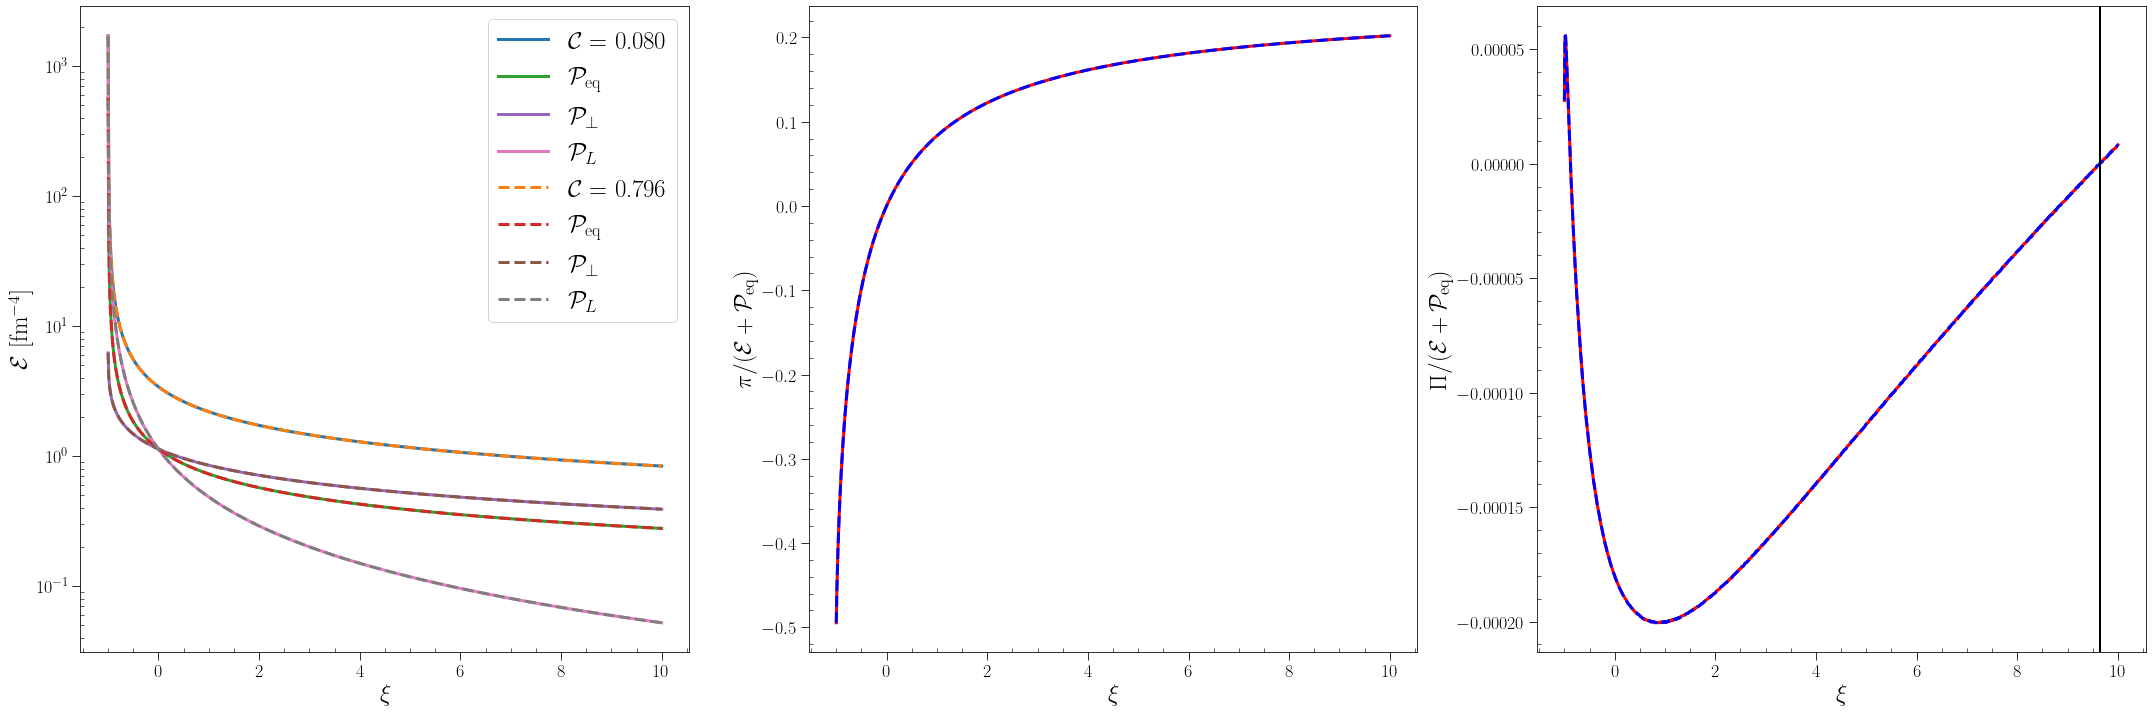

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))
fig.patch.set_facecolor('white')

data = np.array([in_data1, in_data2])

es = np.zeros((2, xis.size))
pts = np.zeros_like(es)
pls = np.zeros_like(es)
ps = np.zeros_like(es)
pis = np.zeros_like(es)
Pis = np.zeros_like(es)

for i in range(2):
    for j in range(xis.size):
        t, e, p, pt, pl, xi = data[i, j]
        es[i, j] = e
        ps[i, j] = p
        pts[i, j] = pt
        pls[i, j] = pl
        pis[i, j] = (pt - pl) / 1.5
        Pis[i, j] = (pl + 2 * pt) / 3 - p

colors = ['red', 'blue']
styles = ['solid', 'dashed']
cmap = get_cmap(10, 'tab10')
for i in range(2):
    ax[0].plot(xis, es[i], lw=3, color=cmap(0+i), ls=styles[i], label=r'$\mathcal C=\ $'+f'{C[i]:.3f}')
    costumize_axis(ax[0], r'$\xi$', r'$\mathcal E$ [fm$^{-4}$]')
    ax[0].set_yscale('log')
    ax[0].plot(xis, ps[i], lw=3, color=cmap(2+i), ls=styles[i], label=r'$\mathcal P_\mathrm{eq}$')
    ax[0].plot(xis, pts[i], lw=3, color=cmap(4+i), ls=styles[i], label=r'$\mathcal P_\perp$')
    ax[0].plot(xis, pls[i], lw=3, color=cmap(6+i), ls=styles[i], label=r'$\mathcal P_L$')
    costumize_axis(ax[1], r'$\xi$', r'$\mathcal P_\mathrm{eq}, \mathcal P_\perp, \mathcal P_L$ [fm$^{-4}$]')
    ax[1].plot(xis, pis[i] / (es[i] + ps[i]), lw=3, ls=styles[i], color=colors[i])
    costumize_axis(ax[1], r'$\xi$', r'$\pi / (\mathcal E + \mathcal P_\mathrm{eq})$') #[fm$^{-4}$]')
    ax[2].plot(xis, Pis[i] / (es[i] + ps[i]), lw=3, ls=styles[i], color=colors[i])
    costumize_axis(ax[2], r'$\xi$', r'$\Pi / (\mathcal E + \mathcal P_\mathrm{eq})$') #[fm$^{-4}$]')

ax[0].legend(loc='upper right', fontsize=25)
#ax[1].legend(loc='upper right', fontsize=25)
index_max = np.argmax(dPi_dtaus_vah1 / Pis1)
ax[2].axvline(x=xis[index_max], lw=2, color='black')

fig.tight_layout()

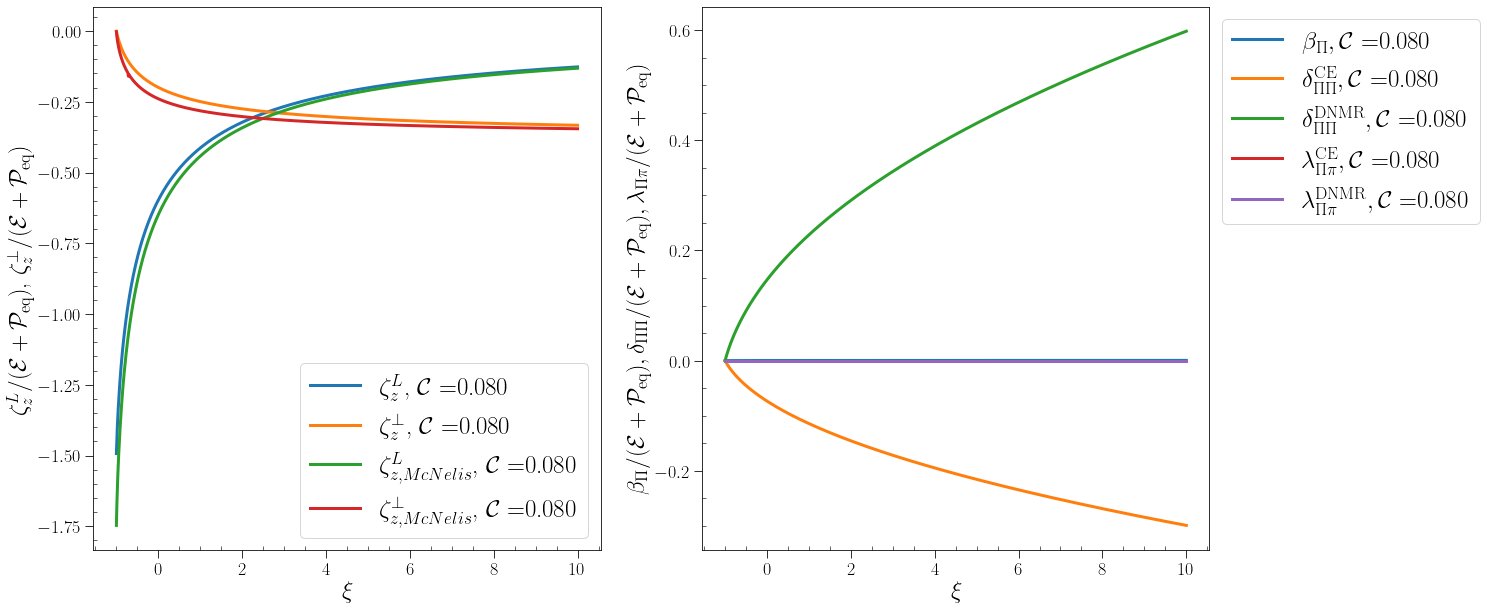

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
fig.patch.set_facecolor('white')

cmap = get_cmap(10, 'tab10')
ls=['solid', 'dashed']
for i in [0]: #range():
    ax[0].plot(xis, zeta_Ls[i] / (es[i] + ps[i]), color=cmap(0), lw=3, ls=ls[i], label=r'$\zeta^L_z$, $\mathcal C = $'+f'{C[i]:.3f}')
    ax[0].plot(xis, zeta_Ts[i] / (es[i] + ps[i]), color=cmap(1), lw=3, ls=ls[i], label=r'$\zeta^\perp_z$, $\mathcal C = $'+f'{C[i]:.3f}') 
    ax[0].plot(xis, zeta_Ls_real[i] / (es[i] + ps[i]), color=cmap(2), lw=3, ls=ls[i], label=r'$\zeta^L_{z,McNelis}$, $\mathcal C = $'+f'{C[i]:.3f}')
    ax[0].plot(xis, zeta_Ts_real[i] / (es[i] + ps[i]), color=cmap(3), lw=3, ls=ls[i], label=r'$\zeta^\perp_{z,McNelis}$, $\mathcal C = $'+f'{C[i]:.3f}')  
    costumize_axis(ax[0], r'$\xi$', r'$\zeta^L_z/(\mathcal E + \mathcal P_\mathrm{eq})$, $\zeta^\perp_z/(\mathcal E + \mathcal P_\mathrm{eq})$')
    ax[0].legend(loc='lower right', fontsize=25)
    
    scale = 0.1
    ax[1].plot(xis, beta_Pi_ce[i] / (es[i] + ps[i]), color=cmap(0), lw=3, ls=ls[i], label=r'$\beta_\Pi, \mathcal C = $'+f'{C[i]:.3f}')
    ax[1].plot(xis, delta_PiPi_ce[i] / (es[i] + ps[i]), color=cmap(1), lw=3, ls=ls[i], label=r'$\delta^\mathrm{CE}_{\Pi\Pi}, \mathcal C = $'+f'{C[i]:.3f}')
    ax[1].plot(xis, delta_PiPi_dnmr[i] / (es[i] + ps[i]), color=cmap(2), lw=3, ls=ls[i], label=r'$\delta^\mathrm{DNMR}_{\Pi\Pi}, \mathcal C = $'+f'{C[i]:.3f}')
    ax[1].plot(xis, lambda_Pipi_ce[i] / (es[i] + ps[i]), color=cmap(3), lw=3, ls=ls[i], label=r'$\lambda^\mathrm{CE}_{\Pi\pi}, \mathcal C = $'+f'{C[i]:.3f}')
    ax[1].plot(xis, lambda_Pipi_dnmr[i] / (es[i] + ps[i]), color=cmap(4), lw=3, ls=ls[i], label=r'$\lambda^\mathrm{DNMR}_{\Pi\pi}, \mathcal C = $'+f'{C[i]:.3f}')
    costumize_axis(ax[1], r'$\xi$', r'$\beta_\Pi/(\mathcal E + \mathcal P_\mathrm{eq}), \delta_{\Pi\Pi}/(\mathcal E + \mathcal P_\mathrm{eq}), \lambda_{\Pi\pi} / (\mathcal E + \mathcal P_\mathrm{eq})$')
    ax[1].legend(loc='upper left', bbox_to_anchor=(1.0,1.0), fancybox=True, fontsize=25)

In [93]:
C = [1 / (4 * np.pi), 10 / (4 * np.pi)]
print(dPi_dtau_vah(es[0,0],pts[0,0],pls[0,0],ps[0,0],GetTemperature(es[0,0],m),tau0,xis[0],C[0]))
print(dPi_dtau_vah_realistic(es[0,0],pts[0,0],pls[0,0],ps[0,0],GetTemperature(es[0,0],m),tau0,xis[0],m,C[0]))
#es[0,0],pts[0,0],pls[0,0],ps[0,0],GetTemperature(es[0,0],m),tau0,C[0]

zeta_L: -3401.8682271092293
zeta_T: -1.6885973356656399
Pi / tr: 1.3725294253514764
E + PL: 3405.3490877708327
-1.0269761244455
zeta_L: -3979.9121201823737
zeta_T: -3.2371254237308875
Pi / tr: 1.3725294253514764
E + PL: 3405.3490877708327
-1936.7909441966765


# 29/11/2021

It seems that the MVAH code does not run well when given aniostropic tempuratures $\Lambda_0< 0.05\ \mathrm{fm}^{-1}$.

# 27/1/2022
Need to solve the problem of the gaussian process emulators not converging

In [4]:
import numpy as np

print(np.outer([[5, 2]], [1e-2,1e2]))

[[5.e-02 5.e+02]
 [2.e-02 2.e+02]]


# 8/2/2022

Met with group on Monday.
Showed that when we train a Gaussian Process emulator with five points and one feature ($\mathcal C$) that we can observe uncetainties bubbles, but that these GPs still fail to converge
<embed src="./scripts/plots/saved_plots/debug_emulator_and_scalers_samples=5.pdf" width="600" height="200" type="application/pdf">
![5-sample-GP]("./scripts/plots/saved_plots/debug_emulator_and_scalers_samples=5.pdf")

# 15/3/2022

Import questions to be consider:
- If using composite measurable, does having non-diagonal matrix relevant?
- We can assume that composite observables are observable directly, and assign error independently of measuring individual observables, i.e. $M_{D^{*+}}-M_{D^+}$ form PDG has its own error bar smaller than the error bar of measuring each separately.

TO DO:
- Run $\Pi$, $\pi$ inference but with correctly calculated errorbars.

What are we doing today:  
<input type="checkbox" disabled="" checked> Run analytic with $\pi$ and $\Pi$ (propagated error) </input>  
<input type="checkbox" disabled="" checked> Run analytic for both with error set to $\alpha_{\mathrm err} = 0.05$ </input>  
<input type="checkbox" disabled="" checked> Run full analysis for $\alpha = 1\times 10^{-2}$ and both analytic predictions </input>  
<input type="checkbox"> 
Run 5 parameter inference  
<ul> This needs to wait until the parameter inversion is implemented. </ul> </input>  
<input type="checkbox">  
Update MAP parameter simulation and analytic prediction to run with arbitrary number of parameters  
<ul> This needs to wait unitl the parameter inversion is implementerd. </ul> </input>  

# 17/3/2022

<input type="checkbox"> Create mini presentation highlight the fruits of your labor: run MCMC chains and calculating analytic posteriors for single parameter inference. </input>  
<input type="checkbox"> Start implementing model comparison technique from Coleman thesis </input>  
<input type="checkbox"> Refactor python code to be separated more logically </input>  

# TO DO:
<input type="checkbox"> Update C++ code to invert observables to get VAH parameters </input>  
<input type="checkbox"> Optimize C++ code to run in parallel to allow for Pyhton multiprocessing </input>